<a href="https://colab.research.google.com/github/sgr1118/GD-NLP/blob/main/%5BGD_10%5D_Made_Translate_With_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-5. 프로젝트: 더 멋진 번역기 만들기

트랜스포머를 사용하여 번역기를 만들고 저번에 만든 Seq2seq와 성능을 비교해보자

1. 사전 준비
- 한글 폰트 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
# 한글 폰트 설치하기
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

In [ ]:
# konlpy 한국어 형태소 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [3]:
# 필요한 라이브러리 불러오기

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import io
import os
import time
import random

import seaborn # Attention 시각화를 위해 필요!

# Step 1. 데이터 다운로드

GD08과 동일한 데이터셋이기 때문에 그대로 사용한다.

데이터 셋 : [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [4]:
# 데이터 불러오기
kor_path = '/content/drive/MyDrive/Aiffel/GD_project/GD8_file/korean-english-park.train.ko'
eng_path = '/content/drive/MyDrive/Aiffel/GD_project/GD8_file/korean-english-park.train.en'

# Step 2. 데이터 정제 및 토큰화



1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [5]:
# 데이터 중복 제거
def clean_corpus(kor_path, eng_path):
  with open(kor_path, "r") as f: kor = f.read().splitlines()
  with open(eng_path, "r") as f: eng = f.read().splitlines()
  assert len(kor) == len(eng)

  # data set 합치기 - zip 사용
  data_set = zip(kor, eng)

  # row_set을 사용하여 중복제거
  cleaned_corpus = set(data_set)

  return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

2. 정제 함수를 아래 조건을 만족하게 정의하세요.

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다. (숫자도 남기도록 설정하였다.)
- 문장 앞뒤의 불필요한 공백을 제거합니다.
- 추가적인 전처리는 GD-08과 같은 데이터 셋이기 때문에 예전 코드를 그대로 사용한다.

In [41]:
# 전처리 함수 구현

def preprocess_sentence(sentence):
  sentence = re.sub(r'(https?:\/\/).+', r'', sentence) # http 링크 삭제
  sentence = re.sub(r'(\\xa0).+', r'', sentence) # 유니코드 삭제
  sentence = re.sub(r'^.*(CNN).*', r'', sentence) # (CNN)이 포함된 문장 전부 삭제
  sentence = sentence.lower() # 텍스트 소문자
  sentence = re.sub(r'[?.!,][/?.!,]', '', sentence) # 여러개 문장 부호를 하나의 문장부호로 바꿉니다.
  sentence = re.sub(r'([?.!,])', r' \1 ', sentence) # 문장부호 양옆에 공백을 추가
  sentence = re.sub(r'[" "]+', " ", sentence) # 여러개 공백을 하나의 공백으로 바꿉니다.
  sentence = re.sub(r"[^a-zA-Z?.!,ㄱ-ㅎ가-힣ㅏ-ㅣ0-9]+", " ", sentence) 
  # ^a-zA-Z?.!,ㄱ-ㅎ가-힣ㅏ-ㅣ0-9가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  sentence = sentence.strip() # 문장 양쪽 공백 제거
    
  return sentence

In [42]:
# preprocess_sentence 예시
# 적용이 깔끔하게 되었다.

preprocess_sentence('행인1:집에서 나가다...')

'행인1 집에서 나가다 .'

In [43]:
# kor, eng 분리

kor_, eng_ = zip(*cleaned_corpus)

print(len(kor_), len(eng_))

78968 78968


In [44]:
# 전처리 시행 후 코퍼스에 담기

kor_corpus = []
eng_corpus = []


for kor, eng in zip(kor_, eng_):
  kor_pre = preprocess_sentence(kor)
  eng_pre = preprocess_sentence(eng)
  kor_corpus.append(kor_pre)
  eng_corpus.append(eng_pre)

In [45]:
# 처리 결과 확인하기
print('kor_process len:',len(kor_corpus), 'eng_process len:',len(eng_corpus))
print(kor_corpus[:5])
print('\n')
print(eng_corpus[:5])

kor_process len: 78968 eng_process len: 78968
['그는 20년 전 땅에서 분출하는 끓는 물을 이용하기로 결정했다 .', 'uae 호화 호텔에서 열린 경매의 수익금은 교통 사고 피해자들을 위한 요양소를 짓는데 쓰여지게 된다 .', '유독성 화학 물질에 불이 붙어 , 화재 진압을 위해 소방관들이 건물에 접근하기가 어려웠으며 , 이 때문에 창고가 화재로 전소되었다 .', '즉 , 값싸고 , 사용하기 쉽고 , 실제로 해독이 불가능한 암호화가 그것이다 .', '제너럴모터스도 적자로 돌아섰고 영국 에너지기업 bp는 이윤이 1 . 5 감소했다 .']


['it s on the farm of gunnar ingvarsson , the 74 year old who decided 20 years ago to tap the boiling hot water spewing out of the ground .', 'proceeds from the auctions , which are held in a lavish hotel here , go to a rehabilitation center for victims of traffic accidents .', 'burning toxic chemicals made it difficult for firefighters to approach the building to extinguish the blaze , which gutted the entire warehouse .', 'cheap , easy to use , and virtually unbreakable encryption .', 'general motors charts , fortune 500 no . 5 lost money too , and bp saw its profits decline 1 . 5 in a year when crude prices remained high .']


3. 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

[google/sentencepiece](https://github.com/google/sentencepiece)

- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다. <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

In [46]:
# sentencepiece 설치

!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.1 MB/s 


[SentencePiece 보충 학습](https://paul-hyun.github.io/vocab-with-sentencepiece/)

- input: 입력 corpus
- prefix: 저장할 모델 이름
- vocab_size: vocab 개수 (기본 20,000개에 특수 토큰 4개를 더해서 20,004개)
- max_sentence_length: 문장의 최대 길이
- pad_id, pad_piece: pad token id, 값
- unk_id, unk_piece: unknown token id, 값
- bos_id, bos_piece: begin of sentence token id, 값
- eos_id, eos_piece: end of sequence token id, 값
- user_defined_symbols: 사용자 정의 토큰

[SentencePiece 참고코드](https://github.com/SIMYJ/NLP_Projects/blob/master/%5BGD_NLP_10%5DTransformer.ipynb)


In [47]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
  
  model_name= 'spm_GD10_'+lang
    
  
  #모델 생성 경로
  temp_file = '/content/drive/MyDrive/Aiffel/GD_project/GD10_'+lang+'.ko'

  # 함수 파라미터 lang의 단어를 적용한 파일 코퍼스 파일 만듬
  with open(temp_file, 'w') as f:
    for row in corpus:   # lang corpus를 활용합니다.
      f.write(str(row) + '\n')
    
  spm.SentencePieceTrainer.Train(
         '\
        --input={} \
        --model_prefix={} \
        --vocab_size={} \
        --pad_id={} \
        --bos_id={} \
        --eos_id={} \
        --unk_id={}'.format(temp_file, model_name, vocab_size, pad_id, bos_id, eos_id, unk_id))
    
  tokenizer = spm.SentencePieceProcessor()
  tokenizer.Load(model_name+'.model')

  return tokenizer

In [51]:
# Sentencepiece 토큰화

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000


ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [52]:
# 생성된 모델 확인

!ls -l spm_GD10_ko*

-rw-r--r-- 1 root root 620785 Oct 17 01:58 spm_GD10_ko.model
-rw-r--r-- 1 root root 401004 Oct 17 01:58 spm_GD10_ko.vocab


In [53]:
# 생성된 모델 확인

!ls -l spm_GD10_en*

-rw-r--r-- 1 root root 574526 Oct 17 01:58 spm_GD10_en.model
-rw-r--r-- 1 root root 354746 Oct 17 01:58 spm_GD10_en.vocab


4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [54]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
  token_ko = ko_tokenizer.encode_as_ids(kor_corpus[idx])
  token_en = en_tokenizer.encode_as_ids(eng_corpus[idx])

  if (len(token_ko) <= 50) and (len(token_en) <= 50):
    src_corpus.append(token_ko)
    tgt_corpus.append(token_en)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다.

enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [55]:
# 토큰화 결과 확인
print(enc_train.shape, dec_train.shape)

(71762, 50) (71762, 50)


# Step 3. 모델 설계

최초의 입력 데이터는 [batch_size * length]의 형태를 가지고 있다.

번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태를 가지게 됩니다. 번역 문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복하는 것이다.

모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 Shape가 바뀌는 과정은 다음과 같다.

1. 입력 데이터 → [ batch_size x length ]

2. Source & Target Embedding → [ batch_size x length x d_emb ]

3. Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.

4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.

1) Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]

2) Masking for Masked Attention

3) Scaled Dot Product Attention

4)Combine Heads →[ batch_size x length x d_emb ]

5. Residual Connection

6. Layer Normalization

7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]

8. Output Linear Layer → [ batch_size x length x vocab_size ]

트랜스포머의 가장 첫 단계인 Positional Encoding부터 구현

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-5.jpg)
<center>Positional Encoding</center>

In [56]:
# Positional Encoding 구현

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

두 번째 구현은 Multi-Head Attention이다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-8.jpg)
<center>Multi-Head Attention</center>

In [57]:
# MultiHeadAttention class 구현

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

세 번째 구현은 Position-wise Feed-Forward Network이다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-17.jpg)
<center>Position-wise Feed-Forward Network</center>


In [58]:
# Position-wise Feed-Forward Network 구현
# 논문 설명 상 d_ff : 2048, d_model : 512이다.
# [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 
# 다시 w_2 를 통해 512차원으로 되돌리는 과정이다.

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

모듈 조립하기

레이어 수를 원하는 만큼 쌓아 실험을 자유자재로 할 수 있게 모델을 완성해야한다.

텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의하면 된다.

첫 번째 구현은 Encoder 레이어 구현하기이다.

In [59]:
# EncoderLayer 구현

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

두 번째 구현은 Decoder 레이어 구현하기이다.

In [60]:
# DecoderLayer 구현

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [61]:
# Encoder 정의

class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [62]:
# Decoder 정의

class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

마지막은 트랜스포머 완성하기이다.

다음 조건을 만족하는 트랜스포머 클래스를 구현하자.

1. shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유 할 수 있게하라.
- Weight가 공유될 경우 Embedding 값에 sqrt(d_model) 을 곱해줘야한다. (참고: tf.keras.layers.Layer.set_weights())

2. 앞에서 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하라 (참고: tf.expand_dims(), np.newaxis)


In [63]:
# 트랜스포머 구현하기

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

그 외에 추가할 내용

1. Maskign 

2. LearningRateScheduler

In [64]:
# Masking 내용 추가

import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

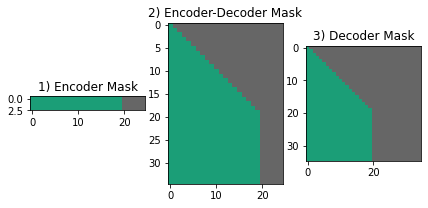

In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [65]:
# LearningRateScheduler 구현

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

# Step 4. 훈련하기











1. 2 Layer를 가지는 Transformer를 선언하세요. (하이퍼파라미터는 자유롭게 조절합니다.)

In [ ]:
# n_layers = 2 적용
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=50,
    dropout = 0.2)

In [66]:
# n_layers = 4 적용
transformer = Transformer(
    n_layers = 4,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=50,
    dropout = 0.2)

2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [67]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-09, name='Adam')

3. Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [68]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [69]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

5. 학습 진행

In [70]:
from tqdm import tqdm_notebook

BATCH_SIZE = 128
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

# Step 5. 결과 출력

1. 번역결과만 출력하기

2. Attention Map 출력하기

3. Bleu_score를 사용하요 seq2seq 모델과 점수 비교해보기

In [71]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [72]:
# 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [73]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

Input: 유독성 화학 물질에 불이 붙어 , 화재 진압을 위해 소방관들이 건물에 접근하기가 어려웠으며 , 이 때문에 창고가 화재로 전소되었다 .
Predicted translation: burning toxic chemicals made it difficult for firefighters to approach the building to extinguish the blaze , which gutted the entire warehouse .
Encoder Layer 1


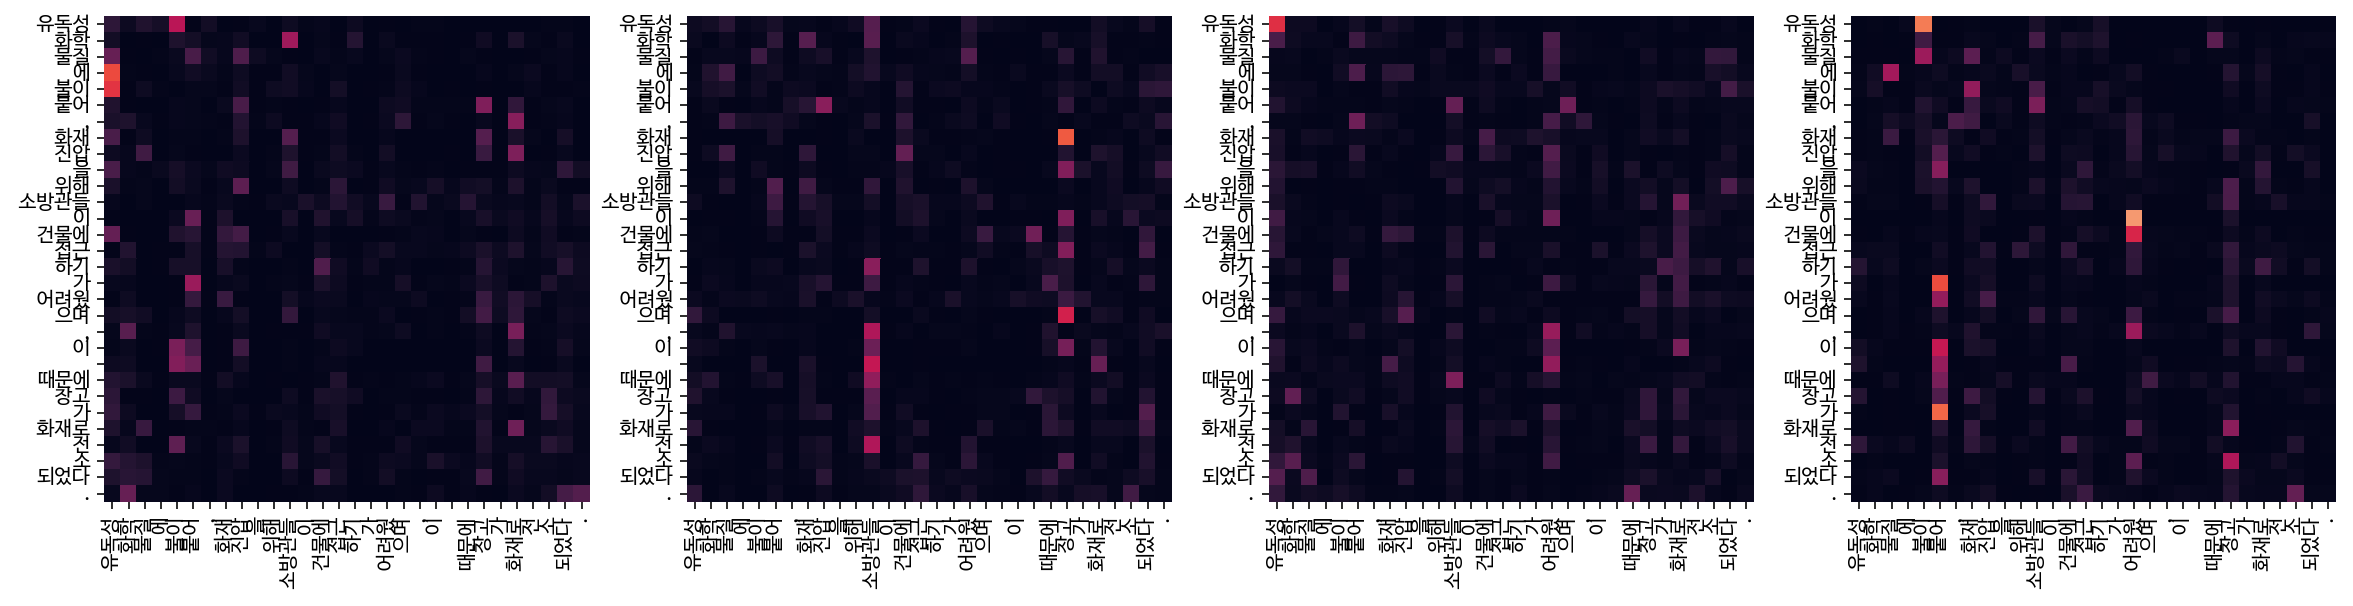

Encoder Layer 2


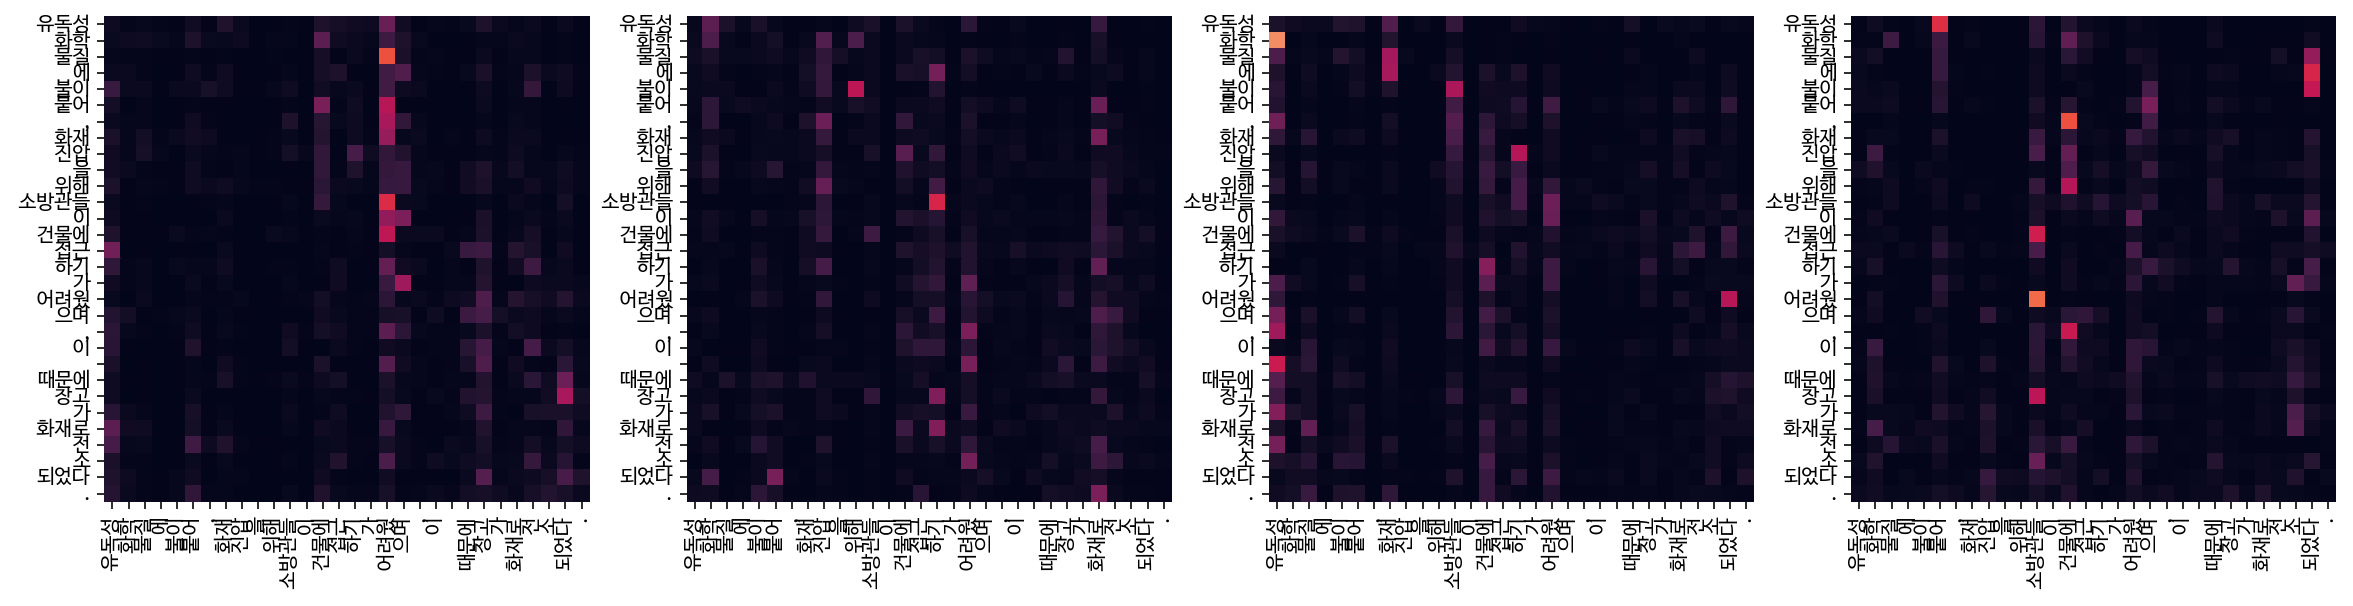

Decoder Self Layer 1


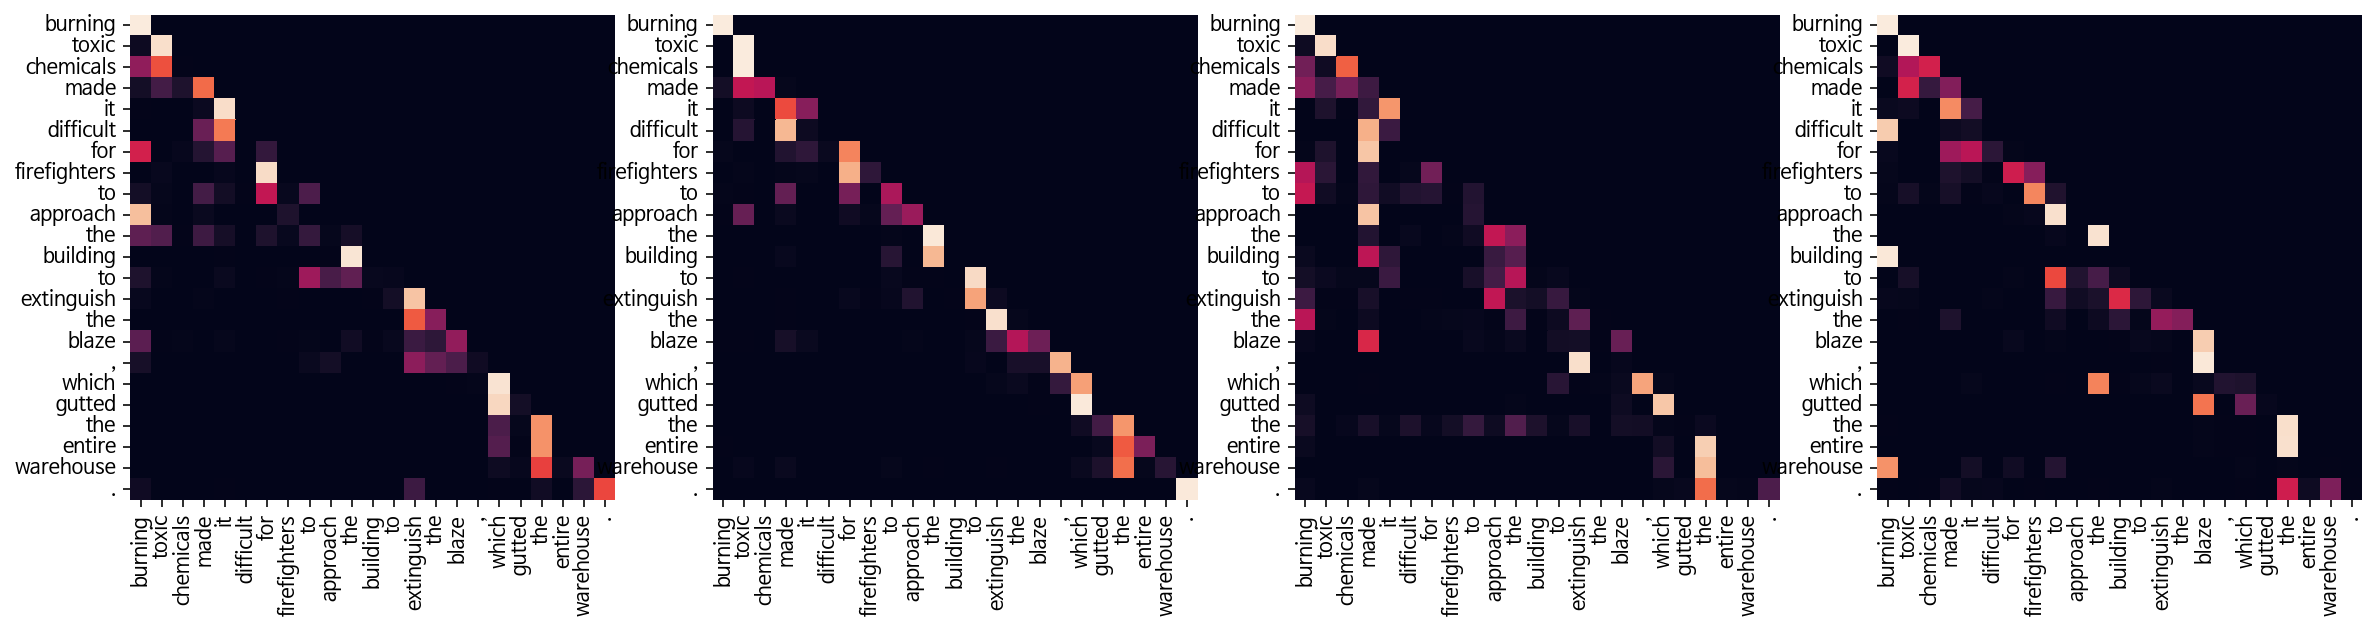

Decoder Src Layer 1


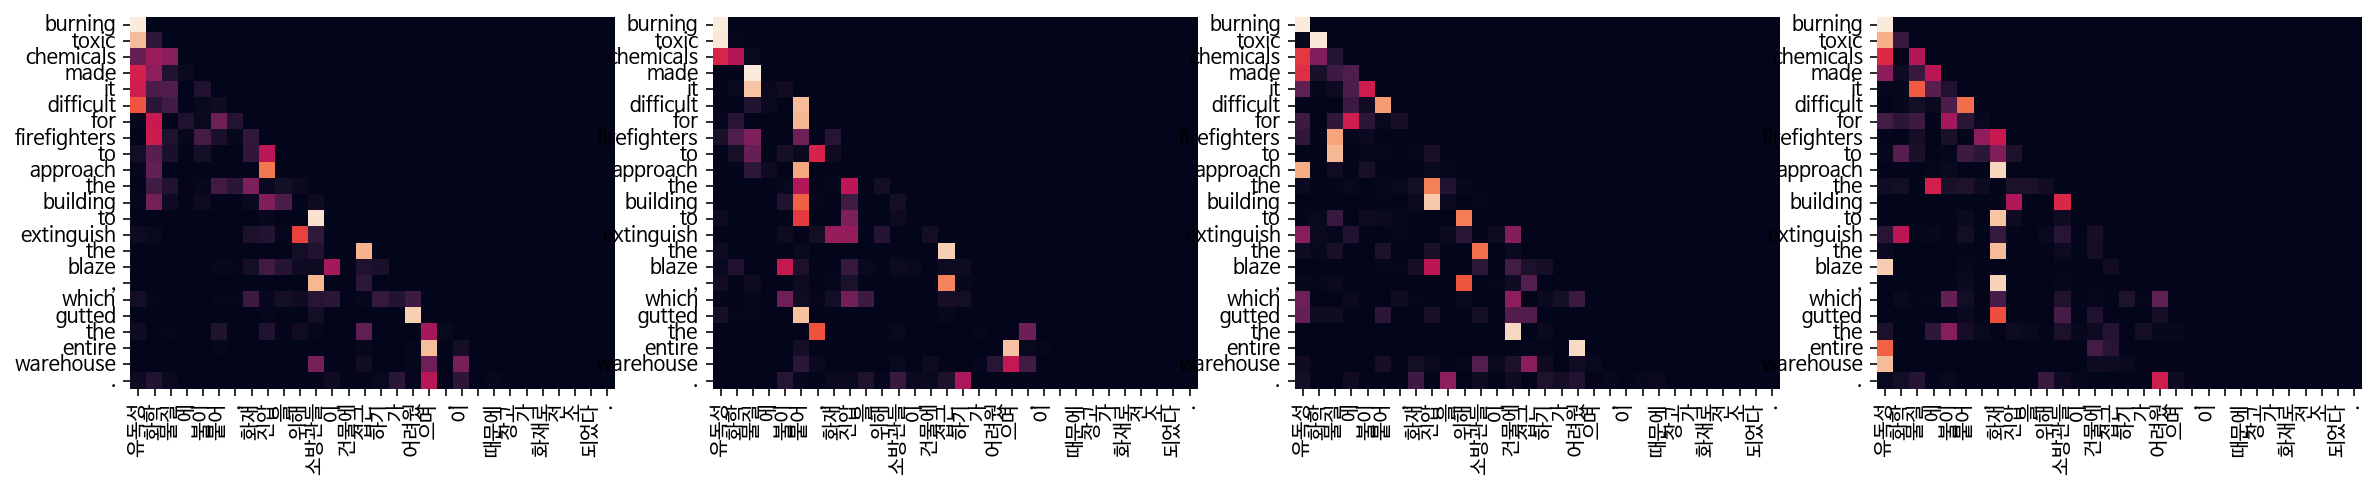

Decoder Self Layer 2


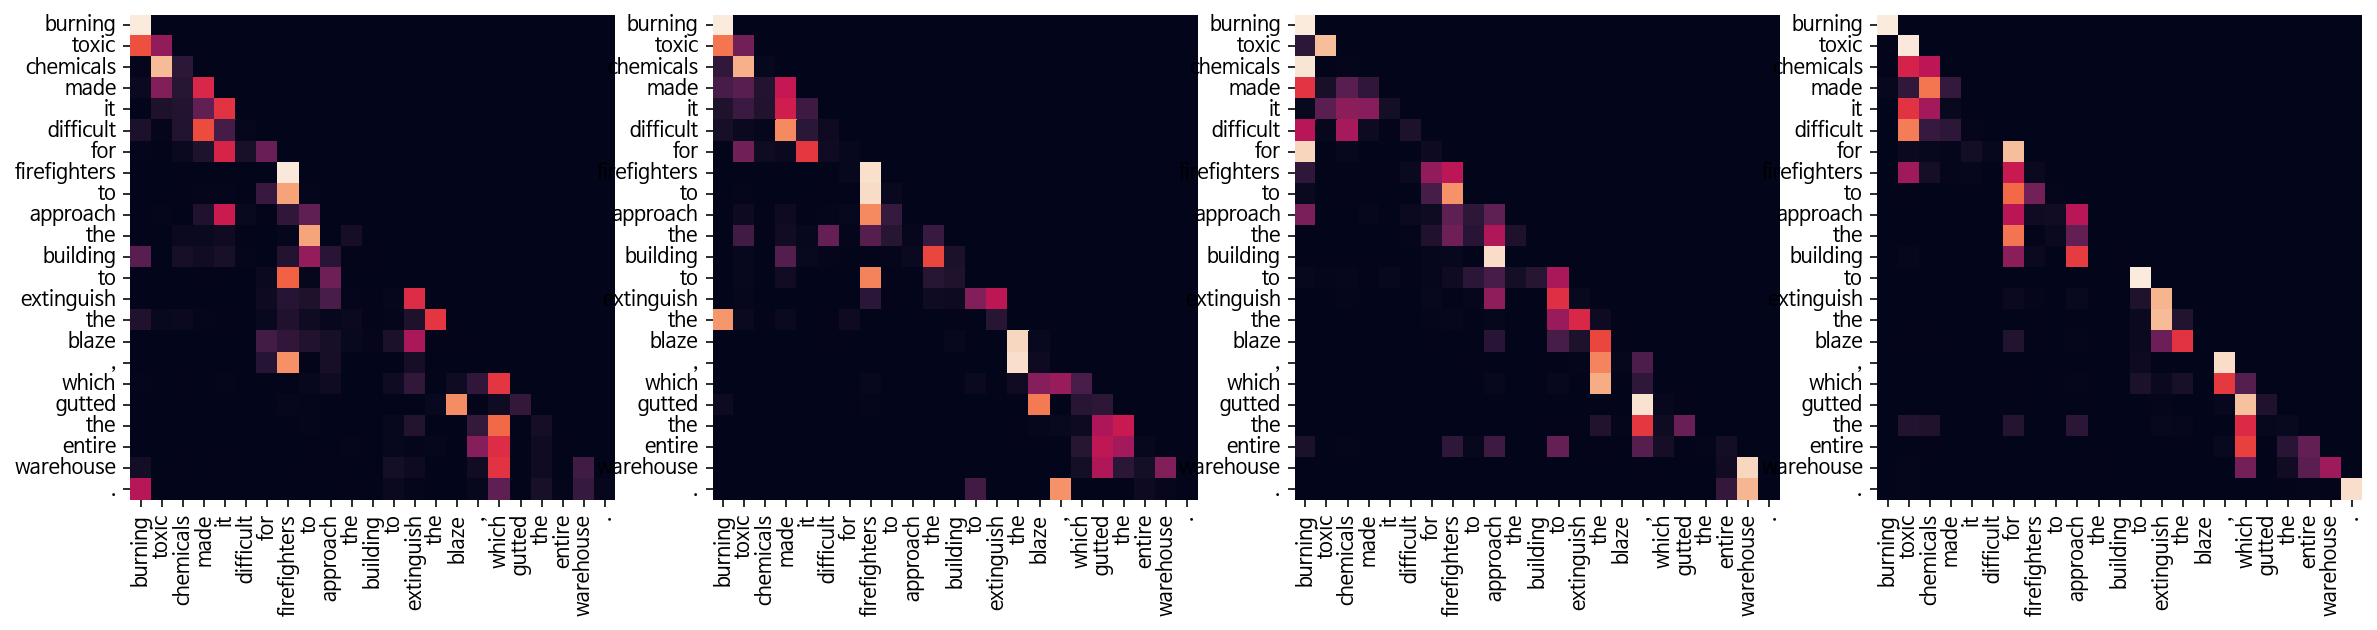

Decoder Src Layer 2


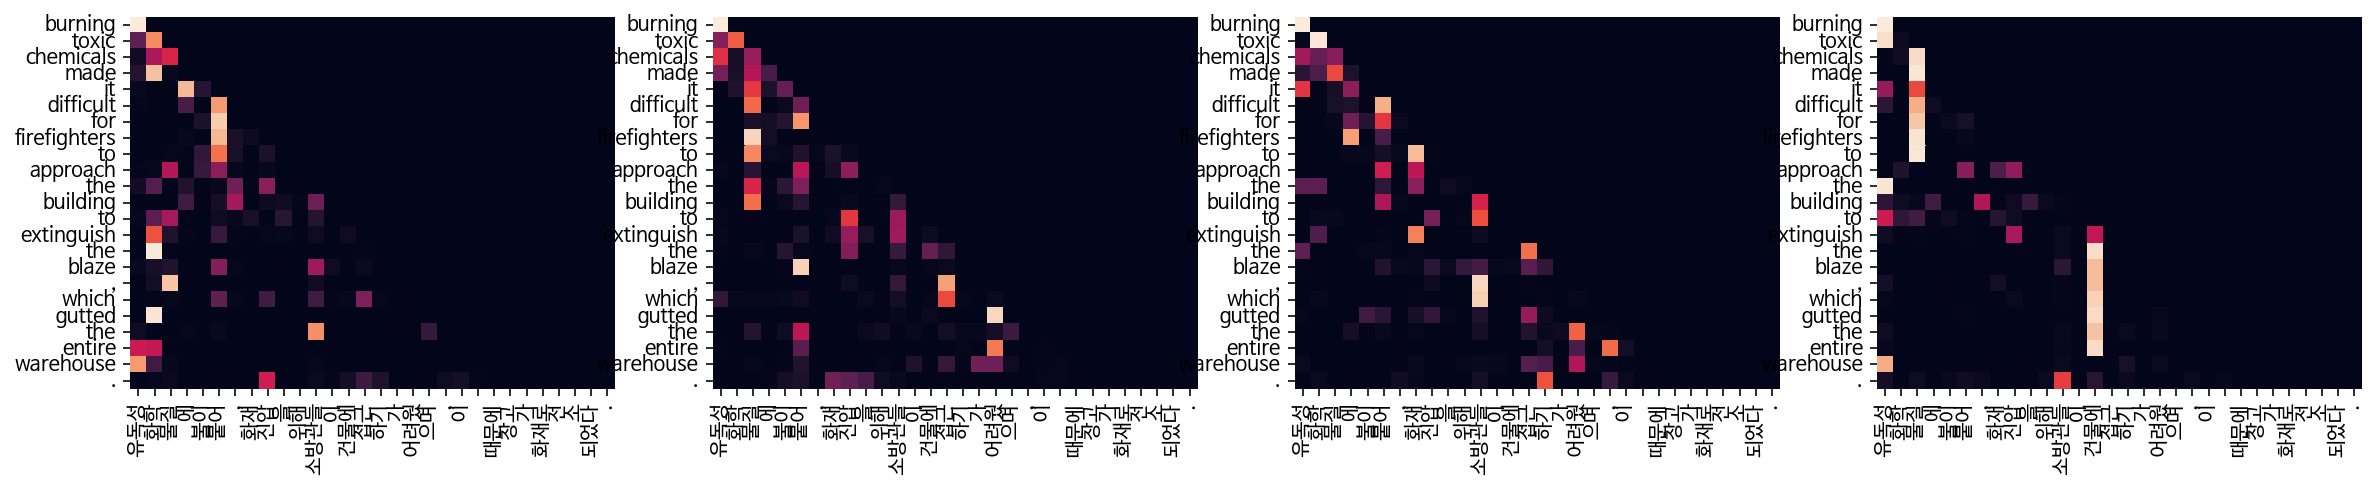

In [92]:
# 번역결과 출력 - Attention Map
test = kor_corpus[2]
translate(test, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

In [99]:
# 문장 랜덤 추출

import random

random = random.sample(kor_corpus, 5)
# 기존에 사용한 train 데이터에서 전처리를 진행한 데이터 사용

# 번역 결과만 출력하기

result = []

for i in random:
  result.append(translate(i, transformer, ko_tokenizer, en_tokenizer))
  print('\n')

Input: 우리는 곧 다시 돌아온다 .
Predicted translation: we will return soon .


Input: 안와르 전 부총리는 자신은 정치적으로 조작된 것이라고 말한 부패 혐의로 1998년 투옥되었다 .
Predicted translation: the former deputy prime minister was jailed in 1998 on corruption charges he has said were politically motivated .


Input: 성명은 또한 미얀마 군정에 반대파 지도자인 아웅산수치와의 성실한 대화 를 준비할 것을 촉구하면서 , 모든 정치범와 남아 있는 수감자들 을 조기 에 풀어줄 것도 요구하고 있다 .
Predicted translation: it also calls for the early release of all political prisoners and remaining detainees , urging the junta to prepare for their statements and determining the political process .


Input: 보안당국은 성직자들이 18일 접촉을 다시 시도했으나 그들은 이들을 만나는 것을 거부했다고 덧붙였다 .
Predicted translation: priests went again sunday , but the followers refused to listen to their arguments , they were in the rest of the country .


Input: 우주선에는 러시아인 , 미국인 그리고 미국인 소프트웨어 억만장자인 찰스 시모니가 탑승했습니다 . 그는 유료 우주관광객으로서 이번이 그의 두 번째 국제우주정거장 방문입니다 .
Predicted translation: it carries a russian , an american , and charles simonyi , an american software 

In [100]:
# 성능 테스트하기

sentences = ['집에 가고싶다!',
             '노는게 제일 좋아!',
             '범인은 감옥에서 사망하였다.',
             '카카오 회사의 주식은 지속적으로 감소하고있다.',
             '만약 내일이 지구가 멸망한다면 난 한 그루의 사과나무를 심겠다.']

result_2 = []

for i in sentences:
  result_2.append(translate(i, transformer, ko_tokenizer, en_tokenizer))
  print('\n')

Input: 집에 가고싶다!
Predicted translation: home of my father , they wanted .


Input: 노는게 제일 좋아!
Predicted translation: like  played the old economy .


Input: 범인은 감옥에서 사망하였다.
Predicted translation: in the last world was picked up .


Input: 카카오 회사의 주식은 지속적으로 감소하고있다.
Predicted translation: the nato led bid is projecting a dolphin .


Input: 만약 내일이 지구가 멸망한다면 난 한 그루의 사과나무를 심겠다.
Predicted translation: if demands tomorrow , the head of the longtime missile project are helped by this country tomorrow .




대략적으로 보았을 때 학습데이터와 비슷한 문구는 번역 성능이 더 좋았고 임의로 만들어낸 문장은 단어가 조금 일치하는 수준이다. Seq2Seq보다는 더 일치하는 단어가 많은 것으로 느껴졌다. 진짜 그러한 수준인지 보기위하여 위에서 사용한 문장으로 Blue_score를 출력해보도록한다.

In [101]:
# BLEU score 라이브러리 불러오기

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [113]:
# 번역 함수 재조정
# 번역 결과만 추출하기위하여 함수를 약간 수정하도록 한다.

def translate_split(sentence, model, src_tokenizer, tgt_tokenizer):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    #print('Input: %s' % (sentence))
    #print('Predicted translation: {}'.format(result))
    return result.split() # Bleu를 사용하기 위하여 띄어쓰기 단위로 단어를 자르도록 한다.

In [141]:
# Blue스코어 출력

sentences = ['우리는 곧 다시 돌아온다 .',
             '그는 억울하다고 주장하였다 .',
             '범인은 감옥에서 사망하였다 .',
             '카카오 회사의 주식은 지속적으로 감소하고있다 .',
             '만약 내일이 지구가 멸망한다면 난 한 그루의 사과나무를 심겠다 .']

references = ["we will be back soon .",
             'he claimed it was unfair .',
             'the perpetrator died in prison .',
             'the shares of the kakao company are continuously declining .',
             'if the earth is destroyed tomorrow, I will plant an apple tree.'] # 실제 번역기 번역

references = [s.split(' ') for s in references]
candidates = []

for sen in sentences:
  candidates.append(translate_split(sen, transformer, ko_tokenizer, en_tokenizer))

In [135]:
# scroe 함수 구현

def score(references, candidates):
  for reference_sen, candidate_sen in zip(references, candidates):
    bleu_1gram = sentence_bleu(reference_sen, candidate_sen, weights=(1, 0, 0, 0))
    
    print(f'reference: {reference_sen}')
    print(f'candidate: {candidate_sen}') 
    print(f'1-Gram BLEU: {bleu_1gram:.2f}')
    print('-'*50)

    return print()



In [142]:
# score 출력

score(references, candidates)

reference: ['we', 'will', 'be', 'back', 'soon', '.']
candidate: ['we', 'will', 'return', 'soon', '.']
1-Gram BLEU: 0.20
--------------------------------------------------
reference: ['he', 'claimed', 'it', 'was', 'unfair', '.']
candidate: ['he', 'says', 'he', 'used', 'the', 'withdrawal', 'of', 'the', 'u', '.', 's', '.', 'is', 'nothing', 'to', 'do', 'with', 'the', 'bureau', '.']
1-Gram BLEU: 0.15
--------------------------------------------------
reference: ['the', 'perpetrator', 'died', 'in', 'prison', '.']
candidate: ['in', 'the', 'last', 'world', 'was', 'picked', 'up', '.']
1-Gram BLEU: 0.13
--------------------------------------------------
reference: ['the', 'shares', 'of', 'the', 'kakao', 'company', 'are', 'continuously', 'declining', '.']
candidate: ['the', 'nato', 'led', 'bid', 'is', 'projecting', 'a', 'dolphin', '.']
1-Gram BLEU: 0.22
--------------------------------------------------
reference: ['if', 'the', 'earth', 'is', 'destroyed', 'tomorrow,', 'I', 'will', 'plant', 'an', 

# Seq2Seq와 비교한 결과

1. Seq2Seq에서는 전처리를 한 학습데이터를 넣어서 성능을 평가했음에도 불구하고 1-gram 기준 0.11이 최대였다.

2. 그러나 트랜스포머를 사용한 번역기의 성능은 0.22까지 성능이 성장하였다. 전처리 또는 파라미터를 바꾼다면 더 좋은 성능이 나올 것으로 기대된다.

# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) SentencePiece를 적용하여 토크나이저를 만드는 방법이 쉽지 않았습니다.
 - 구글링을 통하여 다음 코드를 참고하여 토크나이저를 진행하였습니다.
 - [참고코드](https://github.com/SIMYJ/NLP_Projects/blob/master/%5BGD_NLP_10%5DTransformer.ipynb)

 (2) 기대보다 못미치는 성능
- Seq2Seq보다 더 좋은 성능은 보였지만 아쉬운 부분이 많았다.

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 자연어처리 평가지표 : Bleu score
- 저번에 사용한 Rouge socre말고 이번에는 Bleu score를 사용해보았습니다.
- 기계 번역에서 모델이 번역한 문장과 실제 번역문을 단어 단위로 나눠 어느정도의 유사성을 가지고 있는지 알 수 있는 방식입니다.








참조

(1) [BLEU score 참고 1](http://incredible.ai/nlp/2020/02/29/BLEU/)

(2) [BLEU score 참고 2](https://jrc-park.tistory.com/273)

